In [1]:
import numpy as np

In [74]:
def pairwize(array):
    return np.transpose(np.stack([np.roll(array, -i) for i in range(2)]))

def fitness(solution, distance):
    cost = 0
    pairs = pairwize(solution)
    for edge in pairs:
        cost += distance[tuple(edge)]
    return cost 

def get_travel(solution, city_points):
    travel = []
    for v in solution:
        travel.append(city_points[v])
    travel.append(city_points[solution[0]])
    return np.array(travel)

def init_tsp(NB_CITIES):
    cities = np.random.rand(NB_CITIES, 2)

    distances = np.zeros((NB_CITIES, NB_CITIES))

    for from_city, p1 in enumerate(cities):
        for to_city, p2 in enumerate(cities):
            if from_city != to_city:
                distances[from_city][to_city] = distances[to_city][from_city] = np.linalg.norm(p1-p2)
                
    np.fill_diagonal(distances, 0.000000000000001)
    return cities, distances

def init_tsp_circular(NB_CITIES):
    cities = np.random.rand(NB_CITIES, 2)
    cities[:,0] = np.cos(np.linspace(0, 2*np.pi, NB_CITIES))
    cities[:,1] = np.sin(np.linspace(0, 2*np.pi, NB_CITIES))
    distances = np.zeros((NB_CITIES, NB_CITIES))

    for from_city, p1 in enumerate(cities):
        for to_city, p2 in enumerate(cities):
            if from_city != to_city:
                distances[from_city][to_city] = distances[to_city][from_city] = np.linalg.norm(p1-p2)
                
    np.fill_diagonal(distances, 0.000000000000001)
    return cities, distances

def get_random_solution(NB_CITIES):
    solution=(list(range(NB_CITIES)))
    return np.random.shuffle(solution)

def plot_solution(solution):
    import matplotlib.pyplot as plt
    from copy import deepcopy
    x, y = zip(*get_travel(solution, deepcopy(cities)))
    plt.plot(x,y)
    x, y = zip(*cities)
    plt.scatter(x, y, marker='*') 
    
def getP(visibility, pheromones, alpha=1, beta=1):
    return np.multiply(np.power(visibility, alpha), np.power(pheromones, beta)) / \
        np.sum(np.multiply(np.power(visibility, alpha), np.power(pheromones, beta)))

def P_i(i, visibility, pheromones, alpha=1, beta=1):
    return getP(visibility[i], pheromones[i], alpha=alpha)

def select(P):
    if len(P)==1:
        return 0
    #print(P)
    return np.random.choice(np.arange(len(P)), p=P)



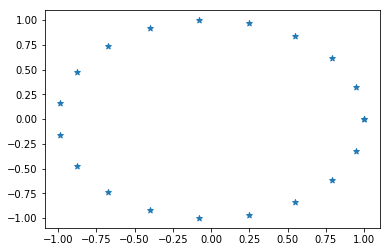

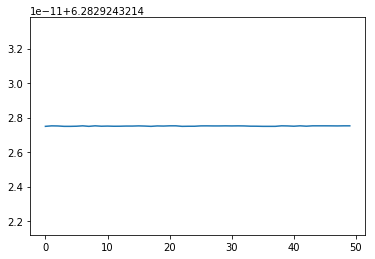

In [77]:
import matplotlib.pyplot as plt
NB_CITIES=20
NB_ANTS  =20
NB_ITER  =50

np.random.seed(0)

cities, distances = init_tsp_circular(NB_CITIES)
visibility = 1 / distances
np.fill_diagonal(visibility, 0)
pheromones = np.ones_like(visibility) / 10
np.fill_diagonal(pheromones, 0)
evaporation = 0.9
Q = 1
L = np.zeros(NB_ANTS)
fit=[]

for iteration in range(NB_ITER):
    solutions = np.zeros((NB_ANTS, NB_CITIES))
    #tabus     = np.ones((NB_ANTS, NB_CITIES), dtype=bool)
    #ids       = np.arange(NB_CITIES)
    for ant in range(NB_ANTS):
        v = np.copy(visibility)
        s = np.random.randint(NB_CITIES)
        solution = np.zeros(NB_CITIES)
        #solutions[ant, 0] = s
        for i in range(1, NB_CITIES):
            p = getP(v[s], pheromones[s], alpha=2)
            v[:, s] = 0
            s = select(p)
            solution[i] = s
        L[ant] = fitness(solution.astype(int), distances)
    pheromones = evaporation * pheromones
    for ant in range(NB_ANTS):
        for edge in pairwize(solutions[ant]):
            pheromones[tuple(edge.astype(int))] += 1 / L[ant]
    best = np.argmin(L)
    fit.append(fitnesses[best])
plot_solution(solutions[best].astype(int))
plt.figure()
plt.plot(fit)

[[ 4.86217783e-01  0.00000000e+00]
 [ 2.94390763e-01  5.24925102e-01]
 [ 1.01859127e-01  2.29994059e-01]
 [-1.02955412e-01  5.85542900e-01]
 [-1.25612495e-01  1.47297152e-01]
 [-9.15281355e-01 -2.04523927e-01]
 [-4.91451665e-01 -4.37192266e-01]
 [ 1.66478682e-01 -3.60194357e-02]
 [ 4.37151454e-01 -4.04132208e-02]
 [ 4.67941595e-01 -2.01692947e-16]]


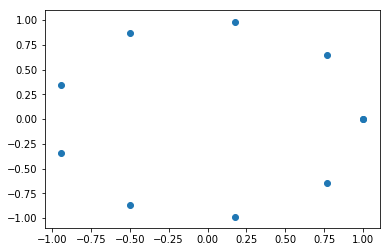

In [64]:
theta = np.ones((10, 2))
theta[:, 0] = np.cos(np.linspace(0., 2*np.pi, 10)) 
theta[:, 1] = np.sin(np.linspace(0., 2*np.pi, 10)) 

# a, b = 1 * np.cos(theta), 1 * np.sin(theta)
r = np.random.rand(10, 2)
print(theta * r)
cities = r * theta
x,y = zip(*cities)
theta = np.linspace(0, 2*np.pi, 10)
r = np.random.rand((10))
x, y =  np.cos(theta),  np.sin(theta)
plt.scatter(x,y)

In [ ]:
#fitnesses = np.apply_along_axis(fitness, axis=1, arr=solutions.astype(int), distance=distances)


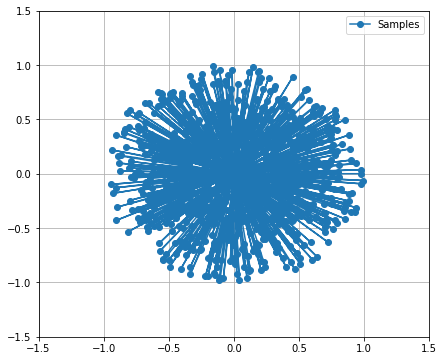

In [67]:
# generate random points in a circle

import numpy as np 
import pylab as plt 


num_samples = 1000

# make a simple unit circle 
theta = np.linspace(0, 2*np.pi, num_samples)
a, b = 1 * np.cos(theta), 1 * np.sin(theta)

# generate the points
# theta = np.random.rand((num_samples)) * (2 * np.pi)
r = np.random.rand((num_samples))
x, y = r * np.cos(theta), r * np.sin(theta)

# plots
plt.figure(figsize=(7,6))
plt.plot(a, b, linestyle='-', linewidth=2, label='Circle')
plt.plot(x, y, marker='o', linestyle='.', label='Samples')
plt.ylim([-1.5,1.5])
plt.xlim([-1.5,1.5])
plt.grid()
plt.legend(loc='upper right')
plt.show(block=True)